In [1]:
import sys
import obspy
from obspy.imaging.beachball import beachball, beach
# from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import PIL
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dateutil import parser
from datetime import datetime, timezone

from sklearn.neighbors import KernelDensity
import seaborn as sns

#from obspy import read_inventory, read_events
import pandas as pd

from scipy import interpolate
from scipy.interpolate import interp1d

from scipy.interpolate import make_interp_spline
from scipy.integrate import * # "quad" function

%matplotlib inline

In [2]:
data = pd.read_csv('sam_eqs.csv', parse_dates=['DATE'])

In [3]:
data.head()

,LON,LAT,DEPTH,DATE,TIME,EVENT_ID,DEPFIX,DEPQUAL,EX,MO,...,SLAB_DIP,CLASS,LON_AVE,LAT_AVE,S_AVE,N_AVE,SINSQ_T,SINSQ_SS,SINSQ_N,TYPE
0,-72.945,-36.078,23.2,2010-02-27,06:34:11.71,348,1.0,L2,22.0,1.858,...,17.674801,MTHRUST,-73.110858,-35.962367,5095.0,-75.0,0.764960,0.019369,0.220404,THRUST
1,-73.515,-16.383,32.0,2001-06-23,20:33:14.98,349,1.0,L1,21.0,4.670,...,24.166351,MTHRUST,-73.589549,-16.523856,2855.0,-75.0,0.750000,0.019369,0.235040,THRUST
2,-71.628,-31.574,29.6,2015-09-16,22:54:32.80,350,False,L2,21.0,3.229,...,22.726843,MTHRUST,-71.749370,-31.547142,4595.0,-75.0,0.793893,0.010926,0.206107,THRUST
3,-70.744,-19.489,21.6,2014-04-01,23:46:47.44,351,1.0,L2,21.0,1.898,...,17.828444,MTHRUST,-70.734127,-19.490035,3265.0,-75.0,0.734736,0.004866,0.250000,THRUST
4,-79.372,1.590,23.8,1979-12-12,07:59:04.44,352,False,L1,21.0,1.690,...,22.748936,MTHRUST,-79.282363,1.479981,415.0,-75.0,0.719186,0.014852,0.265264,THRUST


In [4]:
data['N_AVE'].max()

25.0

In [5]:
# data_0 = data[(data['N_AVE'] > 10)] # towards landwards
data_UP = data.loc[data['CLASS'] == 'UPPER']

data_in_slab = data[data['N_AVE'] > 0] # only in the subducting slab
data_DW = data_in_slab.loc[data['CLASS'] == 'DGOING']

data_MT = data.loc[data['CLASS'] == 'MTHRUST']

In [6]:
data_UP.head()

,LON,LAT,DEPTH,DATE,TIME,EVENT_ID,DEPFIX,DEPQUAL,EX,MO,...,SLAB_DIP,CLASS,LON_AVE,LAT_AVE,S_AVE,N_AVE,SINSQ_T,SINSQ_SS,SINSQ_N,TYPE
29,-72.572,-16.550,54.2,1979-02-16,10:08:54.40,1,False,L1,19.0,6.160,...,0.0,UPPER,-72.636952,-16.616958,2925.0,-125.0,0.569587,0.058526,0.362181,ODD
33,-71.866,-34.350,16.3,2010-03-11,14:55:27.16,4,1.0,L2,19.0,3.490,...,0.0,UPPER,-71.714840,-34.532680,4885.0,-125.0,0.430413,0.002739,0.569587,ODD
38,-71.946,-34.337,12.9,2010-03-11,14:39:44.39,6,1.0,L2,19.0,2.385,...,0.0,UPPER,-72.203762,-34.337780,4885.0,-75.0,0.030154,0.000000,0.969846,NORM
60,-77.947,2.959,29.3,2007-09-10,01:49:13.61,11,False,L1,19.0,1.662,...,0.0,UPPER,-77.849688,2.902092,185.0,-125.0,0.140330,0.001218,0.859670,NORM
88,-70.971,-26.694,20.2,1993-03-15,16:08:57.91,14,False,L1,18.0,6.380,...,0.0,UPPER,-70.870530,-26.744038,4035.0,-75.0,0.328990,0.043227,0.620961,ODD


In [7]:
slab_length = pd.read_csv('sam_at_prof_end_25.csv', sep = ',', header = 'infer')
slab_length=slab_length.append(slab_length, ignore_index=True)
slab_length = slab_length.sort_values(by = 'ALONG',ascending=True)
length = np.asarray(slab_length['LENGTH'])

# Upper plate

In [8]:
data_T_UP = data_UP.loc[(data_UP['TYPE'] == 'THRUST') | (data_UP['TYPE'] == 'O_THRUST')]
data_SS_UP = data_UP.loc[data_UP['TYPE'] == 'SS']
data_N_UP = data_UP.loc[data_UP['TYPE'] == 'NORM']

In [9]:
data_T_UP.head()

,LON,LAT,DEPTH,DATE,TIME,EVENT_ID,DEPFIX,DEPQUAL,EX,MO,...,SLAB_DIP,CLASS,LON_AVE,LAT_AVE,S_AVE,N_AVE,SINSQ_T,SINSQ_SS,SINSQ_N,TYPE
122,-72.096,-33.919,22.7,1985-03-04,06:06:56.29,21,False,L1,18.0,3.630,...,0.0,UPPER,-72.017375,-33.866316,4845.0,-75.0,0.671010,0.105995,0.220404,THRUST
125,-80.906,-5.567,32.5,2014-03-15,23:51:33.04,27,1.0,L2,18.0,3.321,...,0.0,UPPER,-80.718183,-5.568127,1305.0,-125.0,0.924024,0.050603,0.024472,THRUST
284,-79.986,-1.997,55.7,1980-08-18,15:07:53.81,54,False,L1,17.0,9.600,...,0.0,UPPER,-79.857898,-1.951973,865.0,-175.0,0.671010,0.128428,0.192169,THRUST
287,-76.716,-13.649,21.4,2007-08-17,13:18:09.34,56,False,L1,17.0,7.952,...,0.0,UPPER,-76.760188,-13.725869,2375.0,-75.0,0.534878,0.413176,0.058526,O_THRUST
288,-73.293,-38.881,38.7,2004-06-15,11:16:31.34,51,False,L1,18.0,0.931,...,0.0,UPPER,-73.457205,-38.930436,5455.0,-125.0,0.500000,0.465122,0.024472,O_THRUST


In [10]:
data_df = data_T_UP.sort_values(by = 'S_AVE',ascending=True)
data_along_pos = pd.unique(data_df['S_AVE'])
data_along_energy = []

grp = data_df.groupby('S_AVE')

for pos in data_along_pos:
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EX'])
    mo = np.asarray(to_proc['MO'])
    energy = mo*np.power(10., exp)
    data_along_energy.append(np.sum(energy))
    
data_along_energy = np.asarray(data_along_energy)

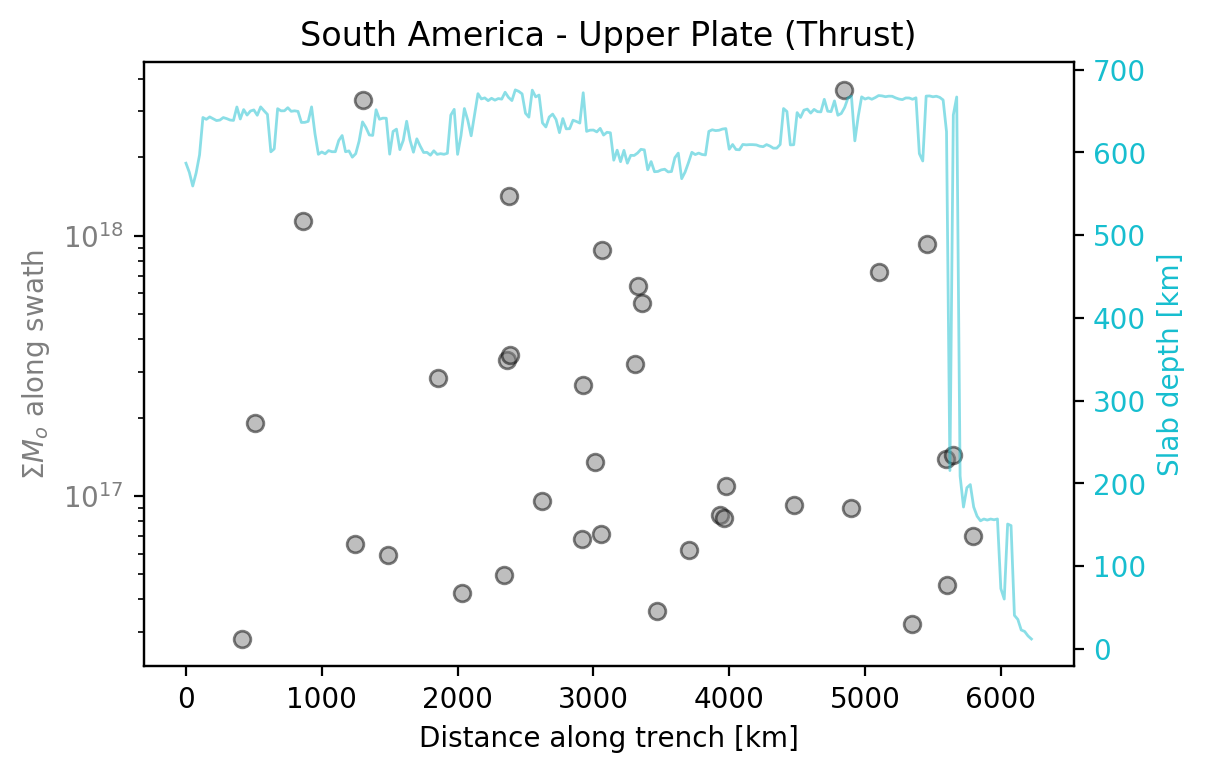

In [11]:
width = 100

fig, ax1 = plt.subplots(dpi = 200)

# plt.yscale('log')
color = 'tab:gray'
ax1.set_xlabel('Distance along trench [km]')
ax1.set_ylabel(r'$\Sigma$$M_o$ along swath', color=color)  # we already handled the x-label with ax1
# plot = ax1.bar(data_along_pos, data_along_energy, color = color, linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.5, label= 'Seismic Moment Release')
plot = ax1.scatter(data_along_pos, data_along_energy, color = color, alpha = 0.5, edgecolor = 'k')
# sns.kdeplot(data_along_energy)


# # Smoothing the curve (https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)
# X_Y_Spline = make_interp_spline(data_along_pos, data_along_energy)
# X_ = np.linspace(data_along_pos.min(), data_along_pos.max(), 300)
# Y_ = X_Y_Spline(X_)
# plot = ax1.plot(X_, Y_, color = color, linewidth = 1)

ax1.tick_params(axis='y', labelcolor=color)

ax1.set_yscale('log')
# ax1.set_ylim([1e16, 1e20]
# ax1.set_ylim([-0.5e19, 1.5e19])
# ax1.set_xlim([0, 5500])
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('Slab depth [km]', color=color)
ax2.plot(slab_length['ALONG'], slab_length['LENGTH']*-1, '-', color=color, alpha = 0.5, markersize = 3, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([-30, 20])
# ax2.set_xlim([0, 5000])
# plt.title('Upper Plate Strike-Slip Earthquakes along trench (1976-2019)')
plt.title('South America - Upper Plate (Thrust)')
plt.savefig('SAM_UP_T.png', dpi = 300)

# MTHRUST

In [12]:
data_df = data_MT.sort_values(by = 'S_AVE',ascending=True)
data_along_pos = pd.unique(data_df['S_AVE'])
data_along_energy = []

grp = data_df.groupby('S_AVE')

for pos in data_along_pos:
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EX'])
    mo = np.asarray(to_proc['MO'])
    energy = mo*np.power(10., exp)
    data_along_energy.append(np.sum(energy))
    
data_along_energy = np.asarray(data_along_energy)

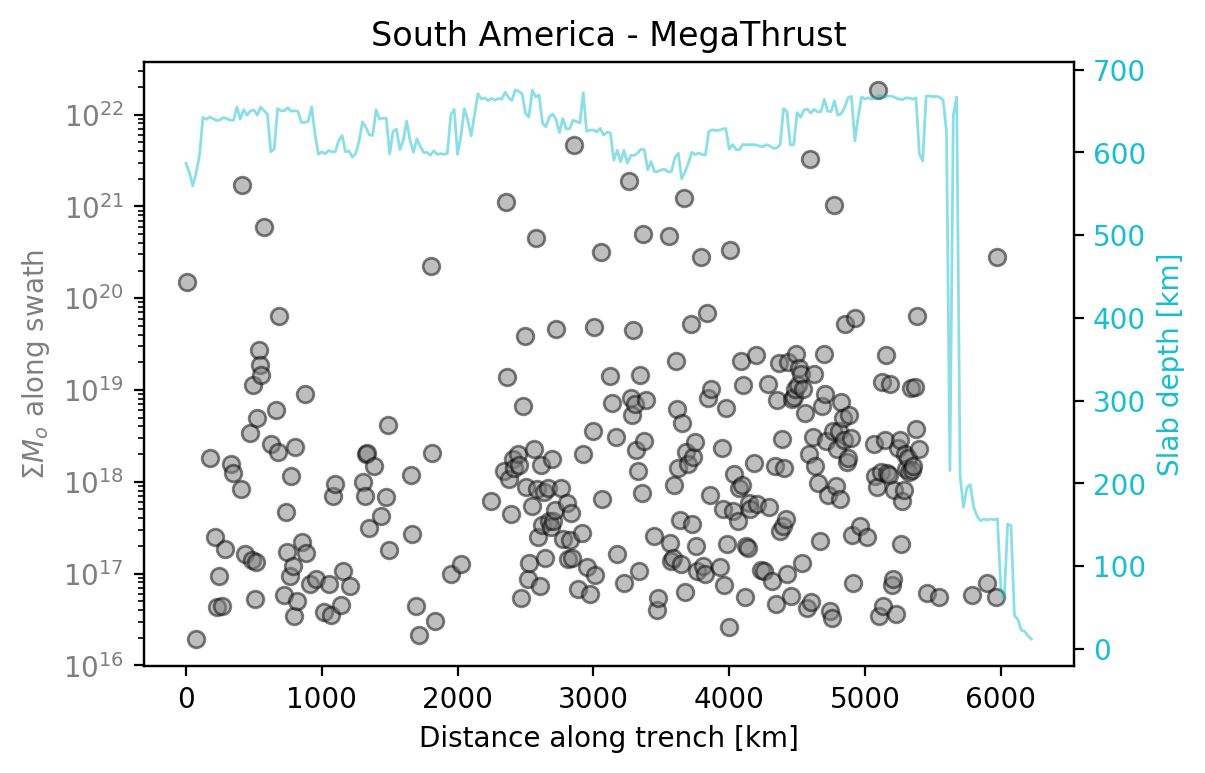

In [13]:
width = 100

fig, ax1 = plt.subplots(dpi = 200)

# plt.yscale('log')
color = 'tab:gray'
ax1.set_xlabel('Distance along trench [km]')
ax1.set_ylabel(r'$\Sigma$$M_o$ along swath', color=color)  # we already handled the x-label with ax1
# plot = ax1.bar(data_along_pos, data_along_energy, color = color, linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.5, label= 'Seismic Moment Release')
plot = ax1.scatter(data_along_pos, data_along_energy, color = color, alpha = 0.5, edgecolor = 'k')
# sns.kdeplot(data_along_energy)


# # Smoothing the curve (https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)
# X_Y_Spline = make_interp_spline(data_along_pos, data_along_energy)
# X_ = np.linspace(data_along_pos.min(), data_along_pos.max(), 300)
# Y_ = X_Y_Spline(X_)
# plot = ax1.plot(X_, Y_, color = color, linewidth = 1)

ax1.tick_params(axis='y', labelcolor=color)

ax1.set_yscale('log')
# ax1.set_ylim([1e16, 1e23])
# ax1.set_ylim([-0.5e19, 1.5e19])
# ax1.set_xlim([0, 5500])
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('Slab depth [km]', color=color)
ax2.plot(slab_length['ALONG'], slab_length['LENGTH']*-1, '-', color=color, alpha = 0.5, markersize = 3, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([-30, 20])
# ax2.set_xlim([0, 5000])
# plt.title('Upper Plate Strike-Slip Earthquakes along trench (1976-2019)')
plt.title('South America - MegaThrust')
plt.savefig('SAM_Megathrust.png', dpi = 300)

# Downgoing plate

In [14]:
data_df = data_DW.sort_values(by = 'S_AVE',ascending=True)
data_along_pos = pd.unique(data_df['S_AVE'])
data_along_energy = []

grp = data_df.groupby('S_AVE')

for pos in data_along_pos:
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EX'])
    mo = np.asarray(to_proc['MO'])
    energy = mo*np.power(10., exp)
    data_along_energy.append(np.sum(energy))
    
data_along_energy = np.asarray(data_along_energy)

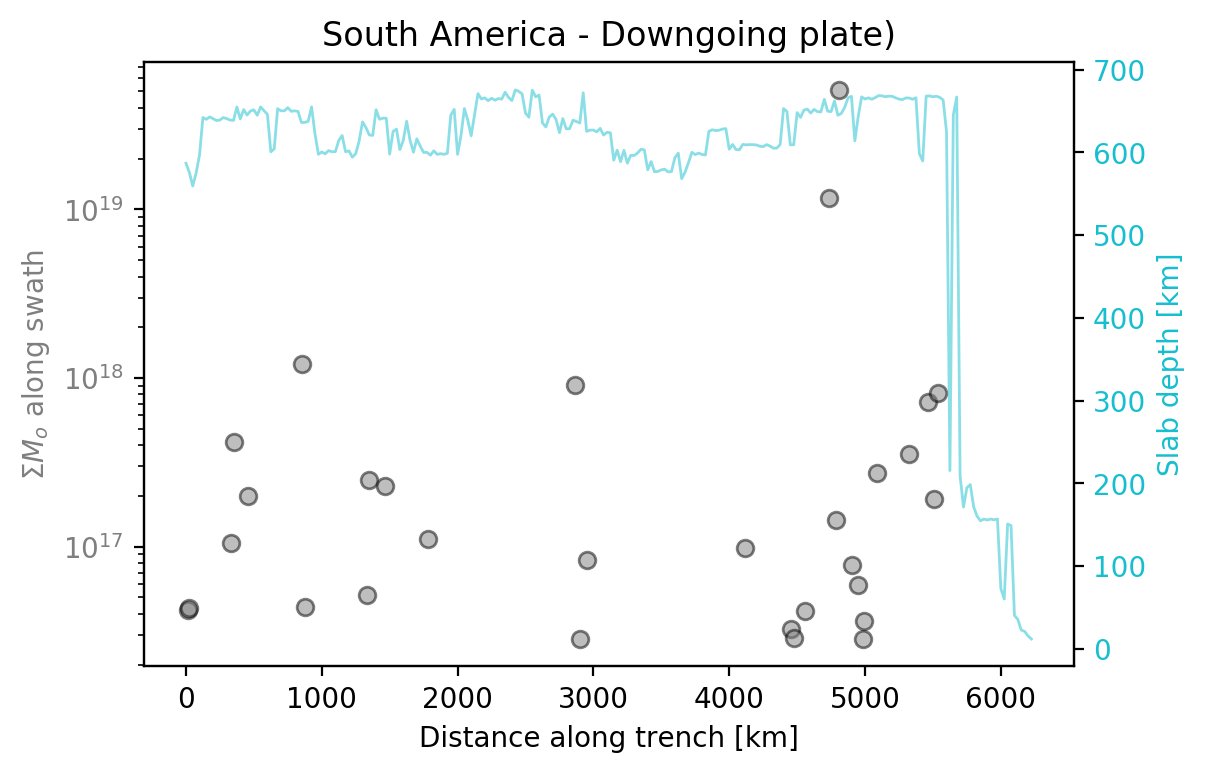

In [15]:
width = 100

fig, ax1 = plt.subplots(dpi = 200)

# plt.yscale('log')
color = 'tab:gray'
ax1.set_xlabel('Distance along trench [km]')
ax1.set_ylabel(r'$\Sigma$$M_o$ along swath', color=color)  # we already handled the x-label with ax1
# plot = ax1.bar(data_along_pos, data_along_energy, color = color, linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.5, label= 'Seismic Moment Release')
plot = ax1.scatter(data_along_pos, data_along_energy, color = color, alpha = 0.5, edgecolor = 'k')
# sns.kdeplot(data_along_energy)


# # Smoothing the curve (https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)
# X_Y_Spline = make_interp_spline(data_along_pos, data_along_energy)
# X_ = np.linspace(data_along_pos.min(), data_along_pos.max(), 300)
# Y_ = X_Y_Spline(X_)
# plot = ax1.plot(X_, Y_, color = color, linewidth = 1)

ax1.tick_params(axis='y', labelcolor=color)

ax1.set_yscale('log')
# ax1.set_ylim([1e16, 1e23])
# ax1.set_ylim([-0.5e19, 1.5e19])
# ax1.set_xlim([0, 5500])
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('Slab depth [km]', color=color)
ax2.plot(slab_length['ALONG'], slab_length['LENGTH']*-1, '-', color=color, alpha = 0.5, markersize = 3, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([-30, 20])
# ax2.set_xlim([0, 5000])
# plt.title('Upper Plate Strike-Slip Earthquakes along trench (1976-2019)')
plt.title('South America - Downgoing plate)')
plt.savefig('SAM_DW.png', dpi = 300)

# Cumulative energy in the downgoing plate and upper plate and both

In [16]:
data.columns

Index(['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'EVENT_ID', 'DEPFIX', 'DEPQUAL',
       'EX', 'MO', 'MW', 'EX.1', 'MRR', 'MTT', 'MPP', 'MRT', 'MTP', 'MPR',
       'STRIKE', 'DIP', 'RAKE', 'STRIKE.1', 'DIP.1', 'RAKE.1', 'EX.2', 'T_VAL',
       'T_PL', 'T_AZM', 'P_VAL', 'P_PL', 'P_AZM', 'N_VAL', 'N_PL', 'N_AZM',
       'SLAB_DIP', 'CLASS', 'LON_AVE', 'LAT_AVE', 'S_AVE', 'N_AVE', 'SINSQ_T',
       'SINSQ_SS', 'SINSQ_N', 'TYPE'],
      dtype='object')

In [17]:
# code for getting the cumulative energy in the downgoing and upper plate and both

ds = 100 # steps in the along direction
s_max = data['S_AVE'].max()

s_arr = np.arange(0, s_max + ds, ds)
s_idx = np.arange(0, s_arr.shape[0], 1) #index for iterating through s_arr

In [18]:
print(s_max)
s_arr

6225.0


array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
         800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
        1600.,  1700.,  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,
        2400.,  2500.,  2600.,  2700.,  2800.,  2900.,  3000.,  3100.,
        3200.,  3300.,  3400.,  3500.,  3600.,  3700.,  3800.,  3900.,
        4000.,  4100.,  4200.,  4300.,  4400.,  4500.,  4600.,  4700.,
        4800.,  4900.,  5000.,  5100.,  5200.,  5300.,  5400.,  5500.,
        5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,  6300.])

In [19]:
cum_energy_up = np.zeros(s_arr.shape[0])
cum_energy_dw = np.zeros(s_arr.shape[0])
# cum_energy_mt = np.zeros(s_arr.shape[0])

In [20]:
# code for getting the cumulative value per bin without using grouby
for i, pos in zip(s_idx, s_arr):
    
    subset_up = data_T_UP[data_T_UP['S_AVE'] == pos]
    subset_dw = data_DW[data_DW['S_AVE'] == pos]

    # work with upper
    exp = np.asarray(subset_up['EX.1'])
    mo = np.asarray(subset_up['MO'])
    energy = mo*np.power(10., exp)
    cum_energy_up[i] = energy.sum() #total energy in this bin
    
    # work with downgoing
    exp = np.asarray(subset_dw['EX.1'])
    mo = np.asarray(subset_dw['MO'])
    energy = mo*np.power(10., exp)
    cum_energy_dw[i] = energy.sum() # total energy in this bin
    
#     print(data_T_UP['S_AVE']);
#     print(pos);
    
# data_along_pos = pd.unique(data_df['ALONG'])     
    
# get total moment per bin by adding cum_energy_dw and cum_energy_up
cum_energy_tot = cum_energy_dw + cum_energy_up
z1 = cum_energy_up / cum_energy_tot
z2 = cum_energy_dw / cum_energy_tot

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [21]:
z1

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

Text(0.5, 1.0, 'Z1 (Upper/total))')

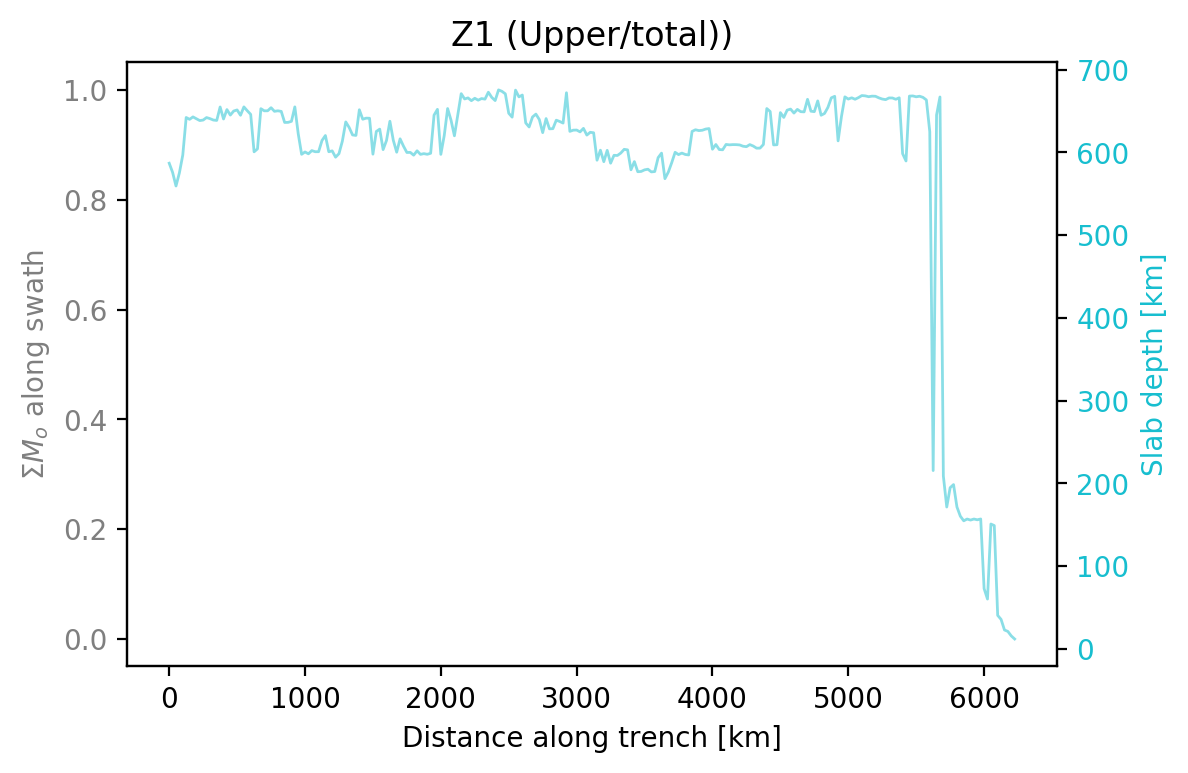

In [22]:
width = 100

fig, ax1 = plt.subplots(dpi = 200)

# plt.yscale('log')
color = 'tab:gray'
ax1.set_xlabel('Distance along trench [km]')
ax1.set_ylabel(r'$\Sigma$$M_o$ along swath', color=color)  # we already handled the x-label with ax1
# plot = ax1.bar(data_along_pos, data_along_energy, color = color, linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.5, label= 'Seismic Moment Release')
plot = ax1.scatter(s_arr, z2, color = color)
# sns.kdeplot(data_along_energy)


# # Smoothing the curve (https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)
# X_Y_Spline = make_interp_spline(data_along_pos, data_along_energy)
# X_ = np.linspace(data_along_pos.min(), data_along_pos.max(), 300)
# Y_ = X_Y_Spline(X_)
# plot = ax1.plot(X_, Y_, color = color, linewidth = 1)

ax1.tick_params(axis='y', labelcolor=color)

# ax1.set_yscale('log')
# ax1.set_ylim([1e16, 1e23])
# ax1.set_ylim([-0.5e19, 1.5e19])
# ax1.set_xlim([0, 5500])
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('Slab depth [km]', color=color)
ax2.plot(slab_length['ALONG'], slab_length['LENGTH']*-1, '-', color=color, alpha = 0.5, markersize = 3, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([-30, 20])
# ax2.set_xlim([0, 5000])
# plt.title('Upper Plate Strike-Slip Earthquakes along trench (1976-2019)')
plt.title('Z1 (Upper/total))')
# plt.savefig('thrust_on_upper.png', dpi = 300)